# **Plant Disease Prediction**

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report,roc_auc_score
import matplotlib.pyplot as plt

import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plant_village = '/kaggle/input/plantvillage-dataset/color'

In [3]:
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3))

94765736/94765736 [==============================] - 0s 0us/step


In [4]:
# freezing the weights of the pretrained ResNet50 layers
for layer in resnet_base.layers:
    layer.trainable = True

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255,input_shape=(224,224,3)),
    
    resnet_base,
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(38,activation='sigmoid')
])
#globalaveragepooling2d is to condence all the feature maps to a single one
#dense is to classify image based on the output from previous layers
#dropout is to prevent overfitting
#batchnormalization to recentre and rescale the input to train faster 

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0

In [7]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=1000,decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [8]:
model.compile(optimizer = optimizer,
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 patience = 5,
                                                 restore_best_weights = True)

In [10]:
train, test = tf.keras.utils.image_dataset_from_directory(plant_village,
                                                         image_size=(224,224),
                                                         batch_size=32,
                                                         seed=123,
                                                         validation_split=0.2,
                                                         subset='both')

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Using 10861 files for validation.


In [11]:
history = model.fit(train, epochs=25, validation_data=test,callbacks=[early_stopping])

Epoch 1/25
1358/1358 [==============================] - 302s 188ms/step - loss: 1.2850 - accuracy: 0.6588 - val_loss: 2.1134 - val_accuracy: 0.4721
Epoch 2/25
1358/1358 [==============================] - 252s 186ms/step - loss: 0.4170 - accuracy: 0.8802 - val_loss: 0.5221 - val_accuracy: 0.8457
Epoch 3/25
1358/1358 [==============================] - 253s 186ms/step - loss: 0.2518 - accuracy: 0.9289 - val_loss: 0.5606 - val_accuracy: 0.8572
Epoch 4/25
1358/1358 [==============================] - 252s 185ms/step - loss: 0.1780 - accuracy: 0.9485 - val_loss: 0.2952 - val_accuracy: 0.9156
Epoch 5/25
1358/1358 [==============================] - 252s 185ms/step - loss: 0.1262 - accuracy: 0.9638 - val_loss: 0.2925 - val_accuracy: 0.9239
Epoch 6/25
1358/1358 [==============================] - 252s 186ms/step - loss: 0.0979 - accuracy: 0.9728 - val_loss: 0.0744 - val_accuracy: 0.9789
Epoch 7/25
1358/1358 [==============================] - 252s 185ms/step - loss: 0.0686 - accuracy: 0.9815 - val_

In [13]:
predictions = model.predict(test)
predicted_labels = tf.argmax(predictions,axis=1)
true_labels = [l for x,l in test.unbatch()]
print(classification_report(true_labels, predicted_labels))

340/340 [==============================] - 19s 56ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00       124
           2       1.00      1.00      1.00        56
           3       1.00      1.00      1.00       348
           4       1.00      1.00      1.00       318
           5       1.00      1.00      1.00       208
           6       1.00      1.00      1.00       147
           7       0.89      0.95      0.92       109
           8       1.00      1.00      1.00       238
           9       0.97      0.94      0.95       200
          10       1.00      1.00      1.00       247
          11       0.99      1.00      1.00       229
          12       1.00      0.99      1.00       274
          13       1.00      1.00      1.00       219
          14       1.00      1.00      1.00        94
          15       1.00      1.00      1.00      1137
          16       1.00 

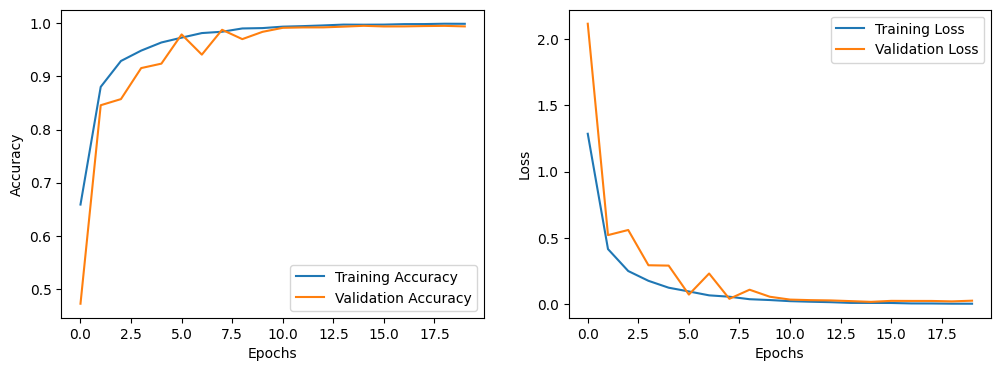

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
tloh = tf.one_hot(true_labels, depth=38)
ploh = tf.one_hot(predicted_labels, depth=38)
roc_auc = roc_auc_score(tloh,ploh, average='macro')
#receiver operating characteristic curve
print("ROC AUC SCORE: ",roc_auc)

ROC AUC SCORE:  0.9955308086762612


In [22]:
tf.math.confusion_matrix(
    true_labels,
    predicted_labels,
    dtype=tf.dtypes.int32,
    name="Confusion Matrix")

<tf.Tensor: shape=(38, 38), dtype=int32, numpy=
array([[ 120,    0,    0, ...,    0,    0,    0],
       [   0,  124,    0, ...,    0,    0,    0],
       [   0,    0,   56, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ..., 1076,    0,    0],
       [   0,    0,    0, ...,    0,   77,    0],
       [   0,    0,    0, ...,    0,    0,  329]], dtype=int32)>

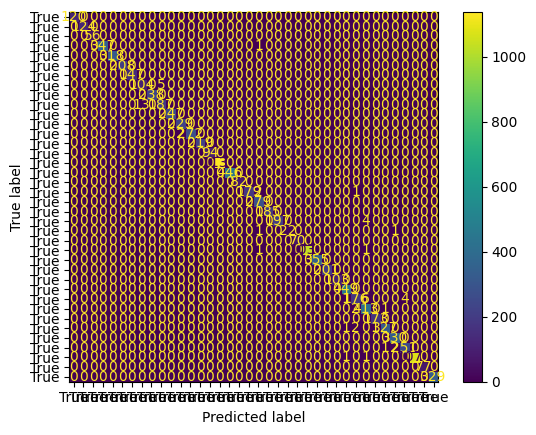

In [35]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(true_labels,predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[True for i in range(38)])
cm_display.plot()
# plt.autoscale(enable=True)
plt.show()

<Axes: >

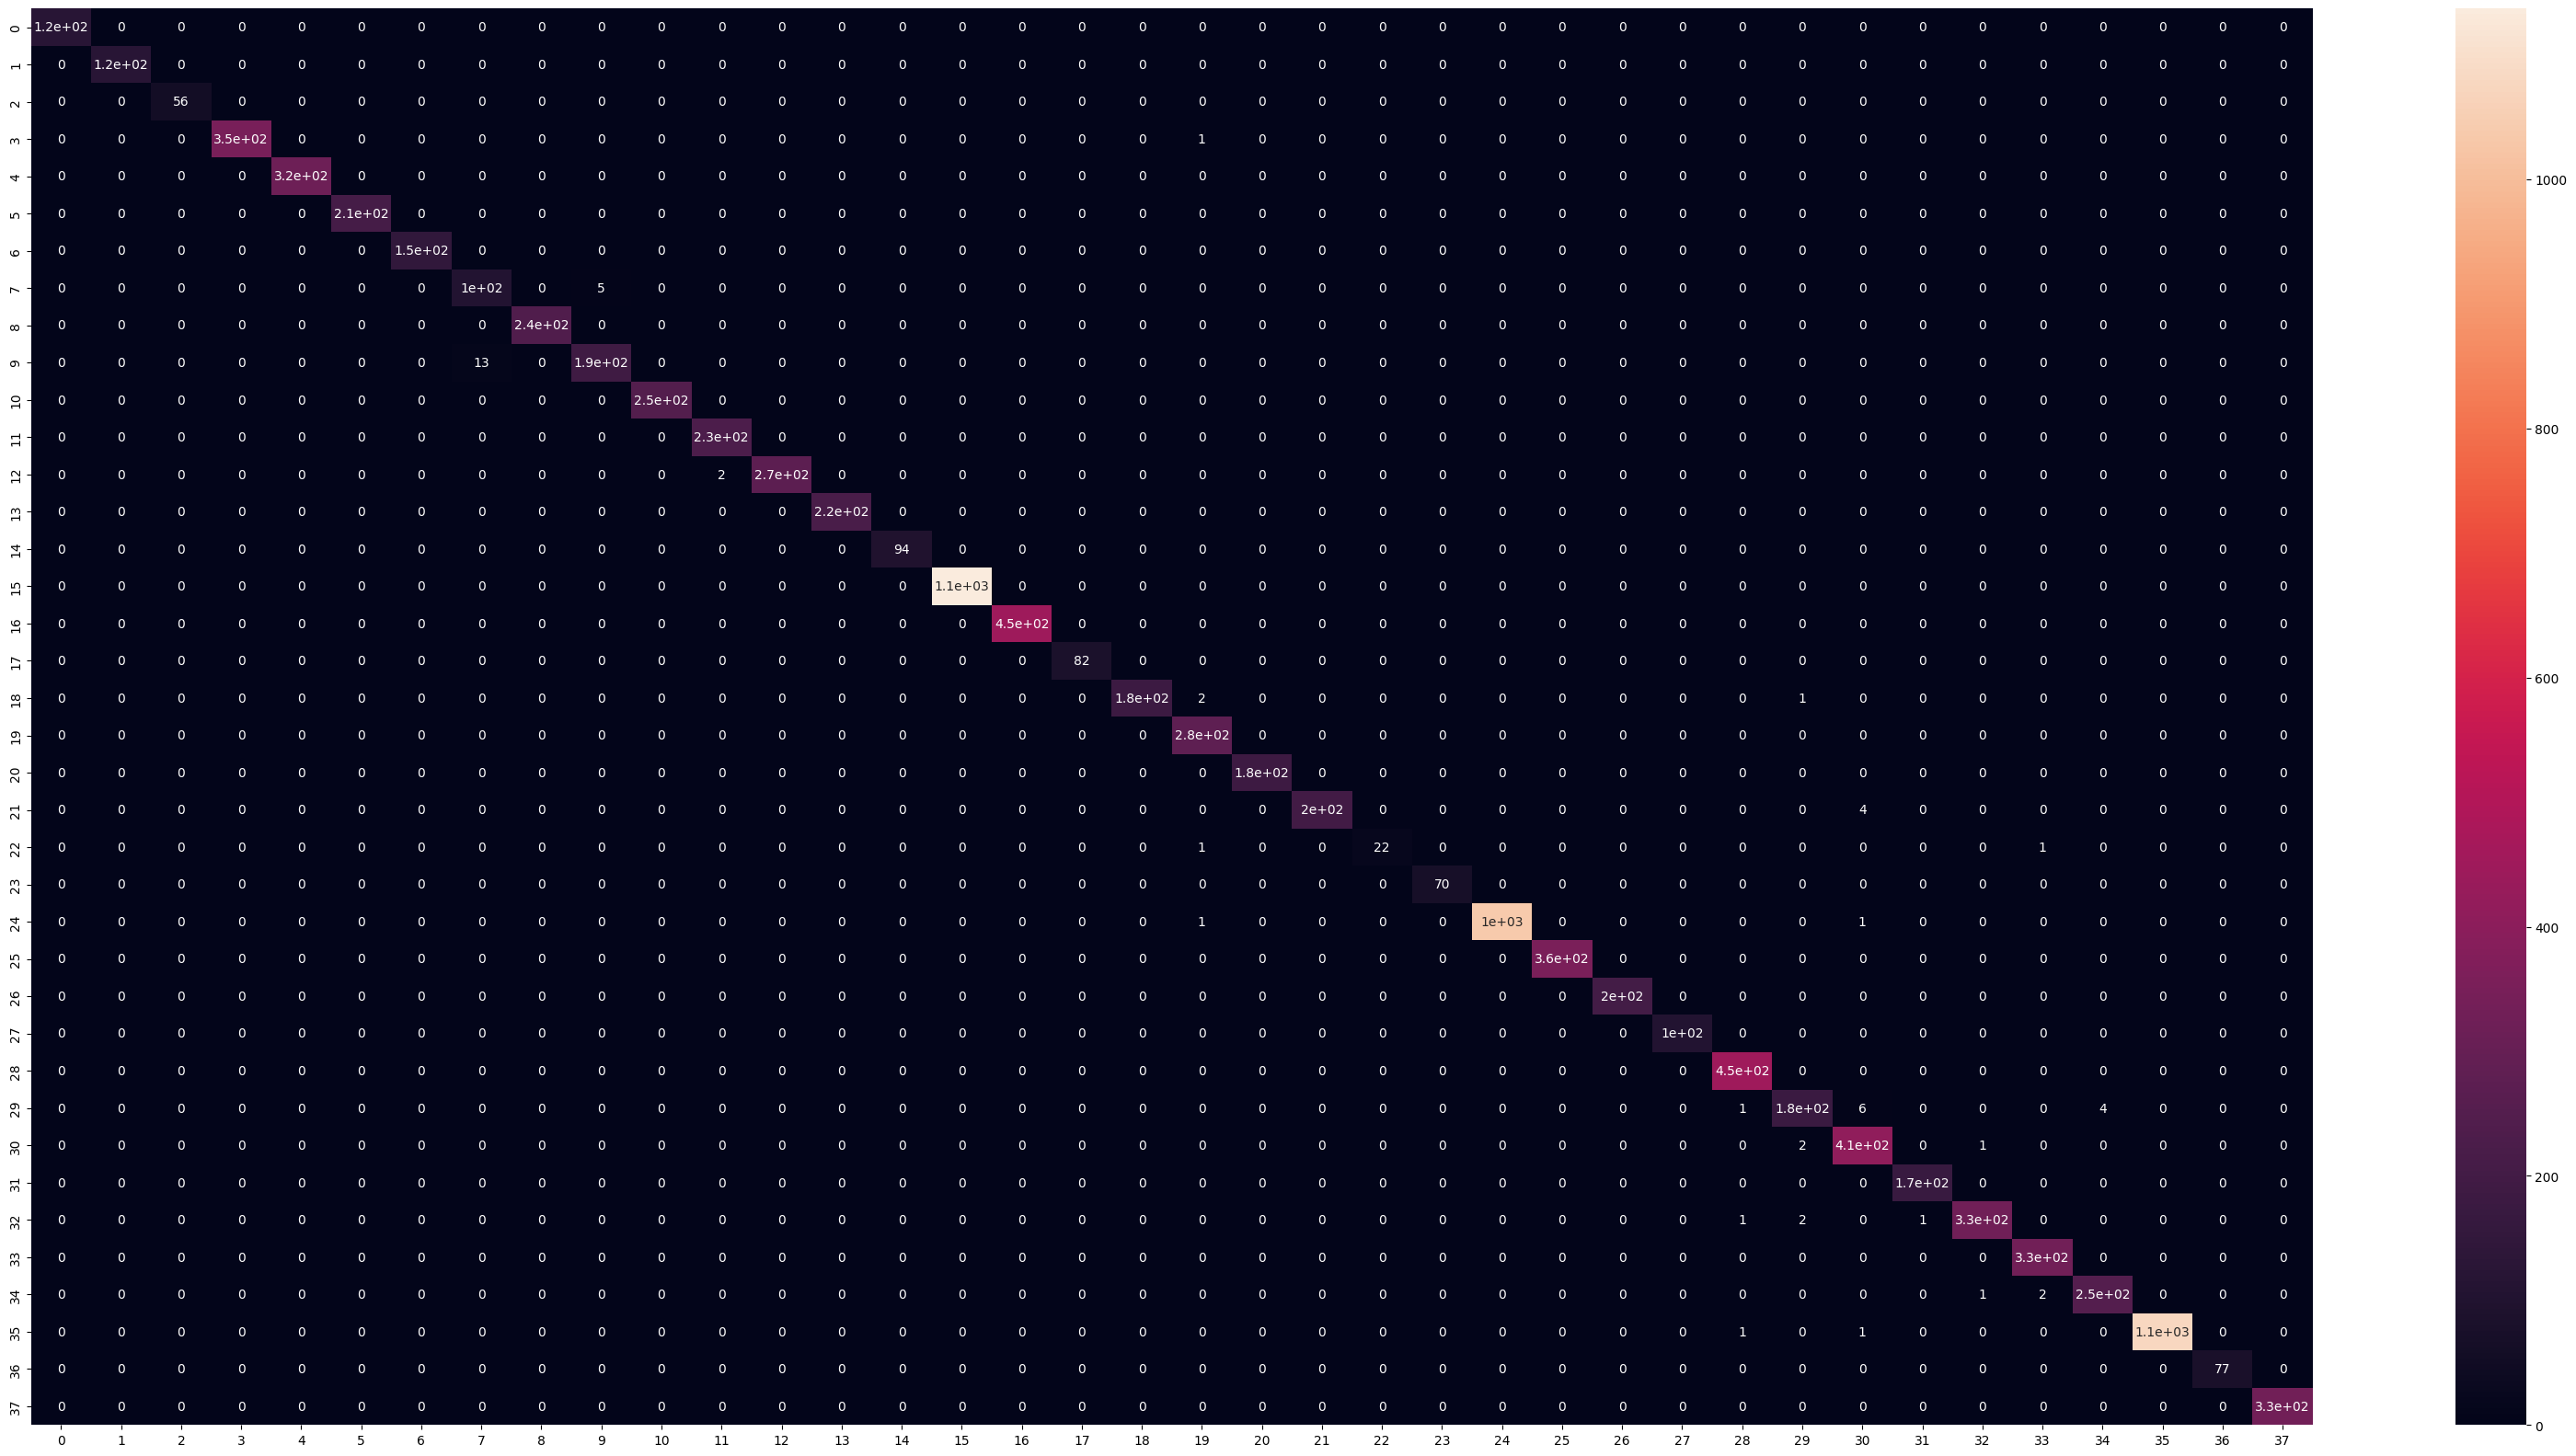

In [36]:
import seaborn as sns
plt.figure(figsize=(40,20))
sns.heatmap(confusion_matrix(true_labels,predicted_labels),annot=True)